In [109]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pyarrow as pa
import os

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D

import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import datetime

from matplotlib.figure import Figure
import seaborn as sns
import math

import matplotlib.animation as animation

In [2]:
sg = pq.read_table('trip_info.parquet')
sg = sg.to_pandas()
sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28000 non-null  int64  
 1   trj_id      28000 non-null  int64  
 2   start_time  28000 non-null  object 
 3   end_time    28000 non-null  object 
 4   ETA         28000 non-null  object 
 5   start_lat   28000 non-null  float64
 6   end_lat     28000 non-null  float64
 7   start_lng   28000 non-null  float64
 8   end_lng     28000 non-null  float64
 9   distance    28000 non-null  float64
 10  cls_TvL     28000 non-null  int32  
dtypes: float64(5), int32(1), int64(2), object(3)
memory usage: 2.2+ MB


In [132]:
def datetimeToHour(string_):
    date_time_obj = datetime.strptime(string_[5:], '%H:%M:%S')
    return int(date_time_obj.strftime("%H"))+int(date_time_obj.strftime("%M"))/60

sg["startTime_hour"] = sg["start_time"].apply(datetimeToHour)
sg["endTime_hour"] = sg["end_time"].apply(datetimeToHour)

ValueError: time data '04-09 11:25:54' does not match format '%H:%M:%S'

In [12]:
def cosTime(int_):
    return math.cos((int_/12) * math.pi)

def sinTime(int_):
    return math.sin((int_/12) * math.pi)

In [13]:
sg['cosTime_start'] = sg["startTime_hour"].apply(cosTime)
sg['sinTime_start'] = sg["startTime_hour"].apply(sinTime)

sg['cosTime_end'] = sg["endTime_hour"].apply(cosTime)
sg['sinTime_end'] = sg["endTime_hour"].apply(sinTime)

In [136]:
def datetimeToHour(string_):
    date_time_obj = datetime.strptime(string_[7:], '%H:%M:%S')
    return int(date_time_obj.strftime("%H"))+int(date_time_obj.strftime("%M"))/60

sg['ETAhour'] = sg["ETA"].apply(datetimeToHour)

In [168]:
def speedCalc(dist, time):
    if int(time)==0:
        return 0;
    return int(dist)/int(time)

sg["speed"] = sg['distance'] / sg['ETAhour']

In [169]:
sg.head()

,Unnamed: 0,trj_id,start_time,end_time,ETA,start_lat,end_lat,start_lng,end_lng,distance,cls_TvL,startTime_hour,endTime_hour,cosTime_start,sinTime_start,cosTime_end,sinTime_end,Clusters,ETAhour,speed
0,0,10,2019-04-09 11:25:54,2019-04-09 11:44:54,0 days 00:19:00,1.301581,1.358010,103.799431,103.845159,9.875596,6,11.416667,11.733333,-0.988362,0.152123,-0.997564,0.069756,4,0.316667,31.186093
1,1,100,2019-04-16 02:44:24,2019-04-16 03:00:37,0 days 00:16:13,1.344114,1.335289,103.938375,103.843102,12.813825,2,2.733333,3.000000,0.754710,0.656059,0.707107,0.707107,2,0.266667,48.051845
2,2,1000,2019-04-11 00:49:45,2019-04-11 01:03:22,0 days 00:13:37,1.434515,1.370538,103.788474,103.860748,13.478591,0,0.816667,1.050000,0.977231,0.212178,0.962455,0.271440,1,0.216667,62.208880
3,3,10001,2019-04-17 11:56:50,2019-04-17 12:17:05,0 days 00:20:15,1.375087,1.328267,103.833377,103.750637,16.901128,1,11.933333,12.283333,-0.999848,0.017452,-0.997250,-0.074108,0,0.333333,50.703385
4,4,10004,2019-04-09 03:12:39,2019-04-09 03:26:37,0 days 00:13:58,1.433348,1.393925,103.768741,103.907360,18.371995,7,3.200000,3.433333,0.669131,0.743145,0.622515,0.782608,1,0.216667,84.793823


In [170]:
X = sg[["start_lat", "start_lng", "end_lat", "end_lng", "cosTime_start", "sinTime_start", "distance"]]

# no of constituencies = 31, approx timeframe = 3, supposed k == 93
max_k = 10

In [171]:
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        pipe = make_pipeline(StandardScaler(), kmeans)
        pipe.fit(X)
        distortions.append(pipe[-1].inertia_)


In [172]:
k = [i*100 for i in np.diff(distortions,2)]
m = 1000000
for n in k:
    if n<m:
        m=n
idxV=m

print(k.index(idxV))
k=k.index(idxV)


kmeans = KMeans(n_clusters = k, init="k-means++")
kmeans = make_pipeline(StandardScaler(), kmeans)
kmeans = kmeans.fit(X)
kmeans = kmeans[-1]

6


In [173]:
kmeans.cluster_centers_

array([[-0.11324595,  1.21028624,  0.39218164, -0.95602982, -0.30810031,
        -0.78712362,  1.13942091],
       [-0.71570124, -0.05388641,  1.24791034, -0.55459837, -0.40528292,
        -0.13225127, -0.10066614],
       [ 1.62853468, -0.38309077, -0.26195641,  0.01678527,  0.18699925,
         0.18523191,  0.01279451],
       [-0.14162829, -0.72681669,  0.00512819,  1.40621673, -0.0895916 ,
        -0.48612239,  1.02509803],
       [-0.2252645 ,  0.91225694, -0.4644599 ,  0.52609863,  0.16524952,
         0.38644678, -0.69425965],
       [-0.30913903, -0.93828759, -0.84176309, -0.33914811,  0.34809476,
         0.41324305, -0.61744725]])

In [174]:
sg['Clusters'] = kmeans.labels_
sg.head()

,Unnamed: 0,trj_id,start_time,end_time,ETA,start_lat,end_lat,start_lng,end_lng,distance,cls_TvL,startTime_hour,endTime_hour,cosTime_start,sinTime_start,cosTime_end,sinTime_end,Clusters,ETAhour,speed
0,0,10,2019-04-09 11:25:54,2019-04-09 11:44:54,0 days 00:19:00,1.301581,1.358010,103.799431,103.845159,9.875596,6,11.416667,11.733333,-0.988362,0.152123,-0.997564,0.069756,1,0.316667,31.186093
1,1,100,2019-04-16 02:44:24,2019-04-16 03:00:37,0 days 00:16:13,1.344114,1.335289,103.938375,103.843102,12.813825,2,2.733333,3.000000,0.754710,0.656059,0.707107,0.707107,4,0.266667,48.051845
2,2,1000,2019-04-11 00:49:45,2019-04-11 01:03:22,0 days 00:13:37,1.434515,1.370538,103.788474,103.860748,13.478591,0,0.816667,1.050000,0.977231,0.212178,0.962455,0.271440,2,0.216667,62.208880
3,3,10001,2019-04-17 11:56:50,2019-04-17 12:17:05,0 days 00:20:15,1.375087,1.328267,103.833377,103.750637,16.901128,1,11.933333,12.283333,-0.999848,0.017452,-0.997250,-0.074108,2,0.333333,50.703385
4,4,10004,2019-04-09 03:12:39,2019-04-09 03:26:37,0 days 00:13:58,1.433348,1.393925,103.768741,103.907360,18.371995,7,3.200000,3.433333,0.669131,0.743145,0.622515,0.782608,2,0.216667,84.793823


In [175]:
# #3d
# %matplotlib notebook
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# # axis equal
# ax.set_xlim3d(103.6, 104)
# ax.set_ylim3d(1.15, 1.55)
# ax.set_zlim3d(0, 40)


# sc = ax.scatter(start[["rawlng"]], start[["rawlat"]], start[["pingtimestamp"]], c=start[["Clusters"]], cmap='viridis', alpha=0.6)

<IPython.core.display.Javascript object>


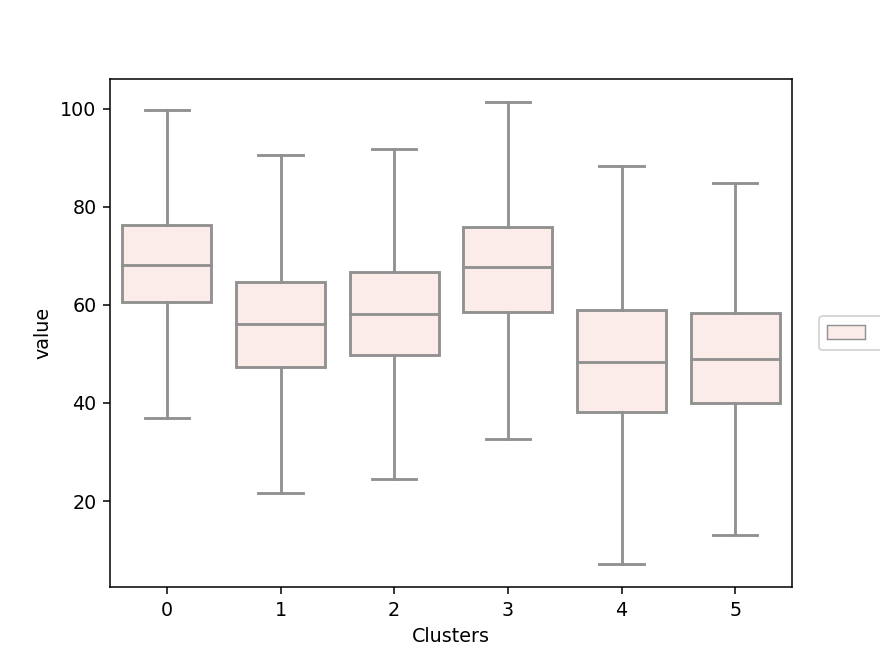

In [176]:
%matplotlib notebook
#sg[sg['Clusters'] == i]

dfl = pd.melt(sg, id_vars='Clusters', value_vars="speed")
sns.boxplot(x='Clusters', y="value", data=dfl, showfliers=False, color='tomato', hue='variable')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)



# plt.scatter(sg[["Clusters"]], sg[["ETAhour"]], c=sg["Clusters"], cmap='viridis')
# ax = plt.gca()
# #ax.axis("equal")
# ax.plot()

<IPython.core.display.Javascript object>


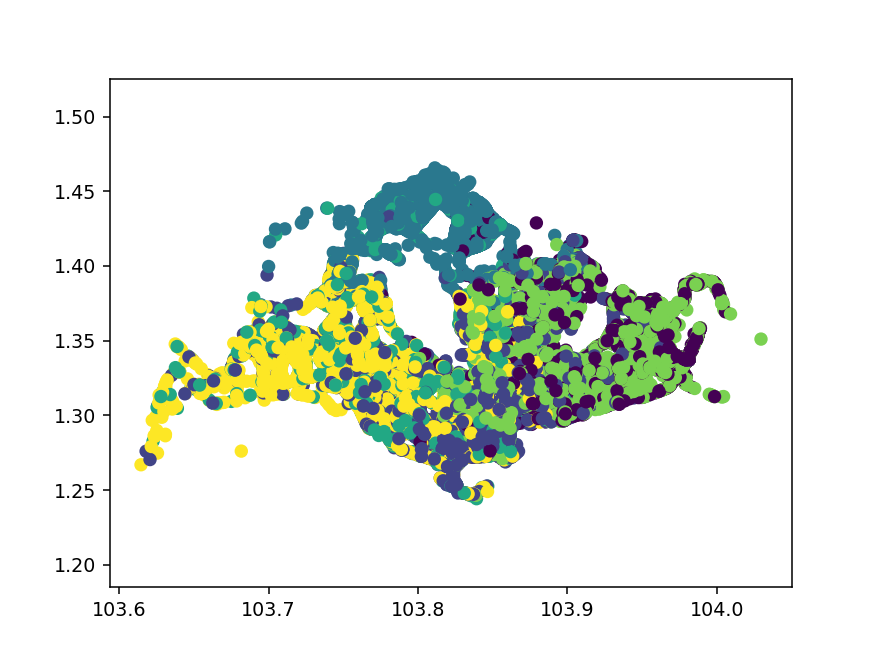

[]

In [179]:
%matplotlib notebook
#["start_lat", "start_lng", "end_lat", "end_lng", "cosTime_start", "sinTime_start", "distance"]
plt.scatter(sg[["start_lng"]], sg[["start_lat"]], c=sg["Clusters"], cmap='viridis')
ax = plt.gca()
ax.axis("equal")
ax.plot()

In [116]:
fig, ax = plt.subplots()
f = Figure(figsize=(7,7))

ax.axis("equal")
scatter = plt.scatter(sg[["start_lng"]], sg[["start_lat"]], c=sg["Clusters"], cmap='viridis')

def update(frame_number):
   scatter.set_offsets(sg[["end_lng"]])
   return scatter,

anim = animation(f, update, interval=10)
plt.show()

TypeError: 'module' object is not callable